In [203]:
import pandas as pd
import numpy as np
import re

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud

### Read in the pre- and post-workshop data for all years available 

In [204]:
pre2014 = pd.read_csv("pre2014.csv")
post2014 = pd.read_csv("post2014.csv")
pre2015 = pd.read_csv("pre2015.csv")
pre2016 = pd.read_csv("pre2016.csv")

### Some initial preprocessing steps

The first thing to do is combine all three of the pre-workshop intake forms into one file. Each of these three files uses slightly different column names for most of the same features, so they need to all be renamed to a standardized column name before merging. 

Note also that many rows contain missing date for the `Date` field, and the 2016 data only includes the year for the `Date` field. We will drop this feature when merging the datasets and instead just aggregate by year. 

In [205]:
# Create mappings for column names of 2014 data
col_mappings_2014 = {'Zip code': 'ZipCode',
                     'Interested in receiving more information': 'MoreInfo',
                     'Status/FInancial Situation': 'Status',
                     'Age Range': 'Age'}

# Create mappings for column names of 2015 data
col_mappings_2015 = {'Zip code': 'ZipCode',
                     'How did you hear about us': 'Source',
                     'Interested in receiving more information': 'MoreInfo', 
                     'Age Range': 'Age'}

# Create mappings for column names of 2016 data
col_mappings_2016 = {'Zip Code:': 'ZipCode', 
                     'Race:': 'Race',
                     'Gender:': 'Gender', 
                     'How did you hear about this workshop?': 'Source',
                     'Current Status (please select one):': 'Status',
                     'Age Range (please select one):': 'Age',
                     'Interested in receiving more information': 'MoreInfo',
                     'Comments / Please Help me With': 'Comments', 
                     'Partner (If Applicable)': 'Partner'}


# Create a "Year" column for each workshop file before merging
for year, file in zip([2014, 2015, 2016], [pre2014, pre2015, pre2016]):
    file['Year'] = year

# Rename columns using the dictionaries above for each file
pre2014 = pre2014.rename(columns = col_mappings_2014)
pre2015 = pre2015.rename(columns = col_mappings_2015)
pre2016 = pre2016.rename(columns = col_mappings_2016)

# Concatenate the three files, drop the date file
df = pd.concat((pre2014, pre2015, pre2016), join='outer', ignore_index=True).drop(columns = ['Date', 'Partner'])

# Preview the combined dataframe output
df.head()

,Workshop,USERID,ZipCode,MoreInfo,Status,Age,Comments,Year,Location,Race,Gender,Source
0,Resume Workshop,14875,20748,Yes,Employed but seeking better opportunities,41-50,I'm not sure at this time,2014,NaN,NaN,NaN,NaN
1,Dream Building,14876,20020,NaN,"Not fulfilled, but not happy",30-34,NaN,2014,NaN,NaN,NaN,NaN
2,Resume Workshop,14877,20746,Yes,Unemployed,51-60,job search,2014,NaN,NaN,NaN,NaN
3,Dream Building,14878,20020,Yes,Fulfilled in life,25-29,NaN,2014,NaN,NaN,NaN,NaN
4,Resume Workshop,14879,20748,NaN,Unemployed,18-25,NaN,2014,NaN,NaN,NaN,NaN


### Additional Cleaning

* The `MoreInfo` column contains multiple possible responses which should be standardized: "Yes", "Y", and "Yes," should all map to "Yes", and "No, thank you.", "N", "No, thank you", and a blank response should all map to "No".
* The `ZipCode` column contains some 5-digit ZIP codes and some 9-digit ZIP codes which should be reduced to 5-digit ZIP codes; all values should be converted to strings and not integer/float (for comparison of categorical variables).
* In some years, '61+' was an option in `Age`, while in other years, '61 & up' was the option instead; these should both be changed to '61+'.
* The `Race` column includes lots of different options for the same three outcomes (e.g. "Black", "African American", "black", etc. all exist in this column); these responses should be more standardized.
* The `Workshop` names vary from year to year and should be standardized a bit more.

In [206]:
# Convert `MoreInfo` to a better representation
df['MoreInfo'] = df.MoreInfo.apply(lambda x: 'Yes' if x in ['Yes', 'Y', 'Yes,'] else 'No')

# Condense 9-digit ZIP codes and convert all to the same representation
df['ZipCode'] = [str(z)[:5] for z in df.ZipCode]

# Combine the responses "61 & up" and "61+" to both be "61+" in the `Age` column
df['Age'] = df.Age.apply(lambda x: '61+' if x == '61 & up' else x)

# Use regex matching to convert the `Race` responses to one of the three observed categorical outcomes
df['Race'] = df.Race.apply(lambda x: 'Black' if bool(re.search(r'(?i)(black)|(african)', str(x))) else x) 
df['Race'] = df.Race.apply(lambda x: 'White' if bool(re.search(r'(?i)white', str(x))) else x)
df['Race'] = df.Race.apply(lambda x: 'Hispanic' if bool(re.search(r'(?i)(hispanic)|(latin.)', str(x))) else x)

# Convert workshop titles to a more standardized set of titles
workshop_names = {'Resume Workshop': 'Resume', 
                  'Budget Workshop': 'Budget',
                  'Creating a Budget': 'Budget',
                  'Landing the Job - Interview': 'Interview',
                  'Resume Building': 'Resume',
                  'Understanding Credit': 'Credit'}
                  
df['Workshop'] = df.Workshop.apply(lambda x: workshop_names[x] if x in workshop_names else x)

df.head()

,Workshop,USERID,ZipCode,MoreInfo,Status,Age,Comments,Year,Location,Race,Gender,Source
0,Resume,14875,20748,Yes,Employed but seeking better opportunities,41-50,I'm not sure at this time,2014,NaN,NaN,NaN,NaN
1,Dream Building,14876,20020,No,"Not fulfilled, but not happy",30-34,NaN,2014,NaN,NaN,NaN,NaN
2,Resume,14877,20746,Yes,Unemployed,51-60,job search,2014,NaN,NaN,NaN,NaN
3,Dream Building,14878,20020,Yes,Fulfilled in life,25-29,NaN,2014,NaN,NaN,NaN,NaN
4,Resume,14879,20748,No,Unemployed,18-25,NaN,2014,NaN,NaN,NaN,NaN


In [207]:
# Save the resulting spreadsheet
df.to_csv('pre_workshop_surveys_2014-2016_cleaned.csv', index=False)

### Make a plot showing the number of participants in each type of workshop, by the year of each workshop

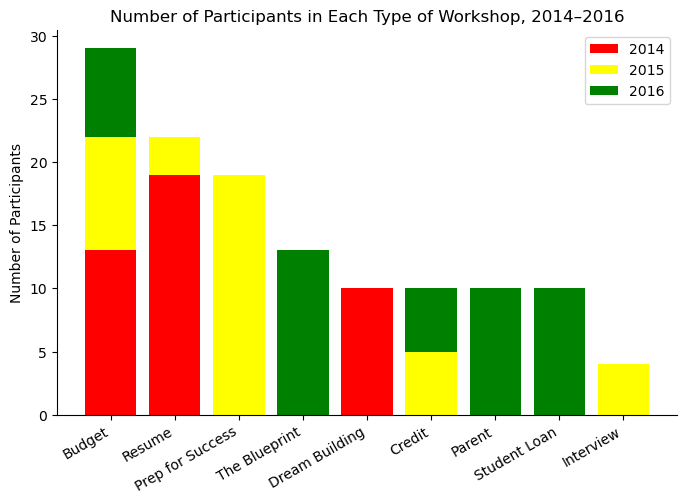

In [208]:
fig, ax = plt.subplots(figsize=(8,5))
sns.despine()

# Extract the names of all workshops held between 2014 and 2016, sorted by number of total participants
workshops = df.Workshop.value_counts().index

# Calculate the number of paricipants from each individual year
d2014 = [len(df[(df.Year == 2014) & (df.Workshop == w)]) for w in workshops]
d2015 = [len(df[(df.Year == 2015) & (df.Workshop == w)]) for w in workshops]
d2016 = [len(df[(df.Year == 2016) & (df.Workshop == w)]) for w in workshops]

# Plot the results and stylize the figure a little bit
ax.bar(range(len(workshops)), d2014, color='red', label='2014')
ax.bar(range(len(workshops)), d2015, color='yellow', bottom=d2014, label='2015')
ax.bar(range(len(workshops)), d2016, color='green', bottom=[d2014[i] + d2015[i] for i in range(len(workshops))], label='2016')
ax.legend()
ax.set_xticks(range(len(workshops)))
ax.set_xticklabels(workshops, ha='right', rotation=30)
ax.set_ylabel('Number of Participants')
ax.set_title('Number of Participants in Each Type of Workshop, 2014–2016')

# Save the figure
plt.savefig('participants_by_workshop_2014-2016.png', dpi=300, bbox_inches='tight')

### Make a plot showing the participants' gender for workshops offered in 2015 and 2016

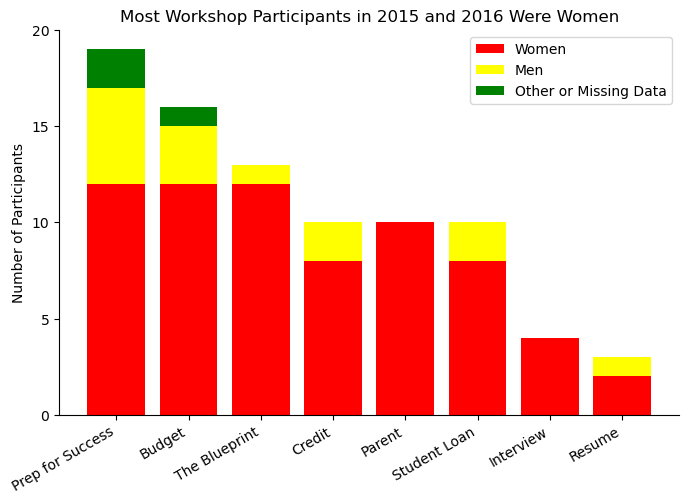

In [209]:
fig, ax = plt.subplots(figsize=(8,5))
sns.despine()

# Subset the data to only include data from 2015 and 2016 (when gender started being asked about)
df = df[df.Year > 2014]
workshops = df.Workshop.value_counts().index

# Calculate the number of women, men, or other/unknown for each workshop
women = [len(df[(df.Gender == 'Female') & (df.Workshop == w)]) for w in workshops]
men = [len(df[(df.Gender == 'Male') & (df.Workshop == w)]) for w in workshops]
other = [len(df[df.Workshop == w]) - women[i] - men[i] for i, w in enumerate(workshops)]

# Plot the results and adjust graphics
ax.bar(range(len(workshops)), women, color='red', label='Women')
ax.bar(range(len(workshops)), men, color='yellow', bottom=women, label='Men')
ax.bar(range(len(workshops)), other, color='green', bottom=[women[i] + men[i] for i in range(len(workshops))], label='Other or Missing Data')
ax.legend()
ax.set_xticks(range(len(workshops)))
ax.set_xticklabels(workshops, ha='right', rotation=30)
ax.set_yticks([0,5,10,15,20])
ax.set_ylabel('Number of Participants')
ax.set_title('Most Workshop Participants in 2015 and 2016 Were Women')

plt.savefig('participants_by_gender_2015-2016.png', dpi=300, bbox_inches='tight')

### Use the post-workshop surveys from 2014 to calculate the average rating for each workshop

In [210]:
# Calculate average ratings and save to a .csv file
post2014.groupby('Workshop Type').mean().to_csv('average_workshop_ratings_2014.csv')

In [165]:
post2014.Feedback.dropna().tolist()

['I enjoyed this session. You spoke on how to read and maintain your credit report. I would also like to hear information on what to do to get out of debt once your credit has gone bad.',
 'not sure',
 'Many thanks, the info regarding budget and explanation very helpful! Will attend additional workshops',
 "Nothing! It was the very best session I've had in a very long time...seriously! (PS: It's the truth!!)",
 'Very informative. Short, sweet, to the point. Maybe have a part 2 session where we can come back with a working resumes (samples) and ask more specific questions',
 'I was glad to be part of this session and it was well presented',
 'Some hands - on (like have us rough draft or edit) like before workshop having a resume sent to you',
 'In creating a sample resume with the participants in the class.',
 'Me being on time',
 'I enjoyed this and learned and some valuable pointers',
 'Have people bring more resumes to work session and do hands on. Give more current sample resumes (e

(-0.5, 799.5, 799.5, -0.5)

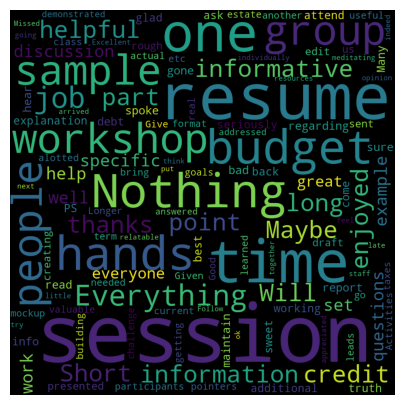

In [201]:
fig, ax = plt.subplots(figsize=(5,5))

# Merge all of the various feedback into one string
feedback = ' '.join(post2014.Feedback.dropna().tolist())

# Create a wordcloud 
wc = WordCloud(width=800, height=800, background_color='black', min_font_size=10).generate(feedback)

# Display the wordcloud, adjust aesthetics, and save the figure                    
ax.imshow(wc)
ax.axis('off')